In [99]:
import time
import odrive
from odrive.enums import *

print("Finding odrv...")
odrv0 = odrive.find_any()

def CALIB():
    print("starting calibration...")
    time.sleep(1)
    odrv0.axis0.requested_state = AXIS_STATE_FULL_CALIBRATION_SEQUENCE
    odrv0.axis1.requested_state = AXIS_STATE_FULL_CALIBRATION_SEQUENCE
    while odrv0.axis0.current_state != AXIS_STATE_IDLE:
        time.sleep(0.1)
    while odrv0.axis1.current_state != AXIS_STATE_IDLE:
        time.sleep(0.1)

    print("setting params axis 0...")
    odrv0.axis0.encoder.set_linear_count(0)
    odrv0.axis0.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL

    print("setting params axis 1...")
    odrv0.axis1.encoder.set_linear_count(0)
    odrv0.axis1.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL

def STOP():
    odrv0.axis0.requested_state = AXIS_STATE_IDLE
    odrv0.axis1.requested_state = AXIS_STATE_IDLE

def rezero(axis, dir): # 1 = CCW, -1 = CW <-- dir indicates which direction you wish it so spin in while in use
    if axis == 0:
        odrv0.axis0.controller.config.control_mode = CONTROL_MODE_POSITION_CONTROL
        odrv0.axis0.controller.config.input_mode = INPUT_MODE_PASSTHROUGH
    if axis == 1:
        odrv0.axis1.controller.config.control_mode = CONTROL_MODE_POSITION_CONTROL
        odrv0.axis1.controller.config.input_mode = INPUT_MODE_PASSTHROUGH

    if axis == 0:
        init = odrv0.axis0.controller.input_pos
        print(init)
        while dir * init > 0:
            odrv0.axis0.controller.input_pos = init
            init += -1 * dir * 0.01
            time.sleep(0.01)
    elif axis == 1:
        init = odrv0.axis1.controller.input_pos
        print(init)
        while dir * init > 0:
            odrv0.axis1.controller.input_pos = init
            init += -1 * dir * 0.01
            time.sleep(0.01)

rezero(axis=0, dir=-1)
rezero(axis=1, dir=1)

import math
L1 = 275
L2 = 275
def q1q2_from_xy(x, y):
    xD_mag = math.sqrt(x*x + y*y)
    c2 = (xD_mag * xD_mag - L1 * L1 - L2 * L2) / (2 * L1 * L2)
    if abs(c2) > 1:
        return None
    if c2 == 1:
        return math.atan2(y, x), 0, math.atan2(y, x), 0
    q2_1 = 1 * math.acos( c2 )
    q2_2 = -1 * math.acos( c2 )
    theta = math.atan2(y, x)
    q1_1 = theta - math.atan2(L2 * math.sin(q2_1), L1 + L2 * math.cos(q2_1))
    q1_2 = theta - math.atan2(L2 * math.sin(q2_2), L1 + L2 * math.cos(q2_2))
    return q1_1, q2_1, q1_2, q2_2
STOP()


Finding odrv...
1.9498223066329956
0.9749111533164978


the object disappeared
'EmptyInterface' object has no attribute 'axis0'
'EmptyInterface' object has no attribute 'axis0'
'EmptyInterface' object has no attribute 'axis0'
'EmptyInterface' object has no attribute 'axis0'
'EmptyInterface' object has no attribute 'axis0'
'EmptyInterface' object has no attribute 'axis0'
'EmptyInterface' object has no attribute 'axis0'
'EmptyInterface' object has no attribute 'axis0'
'EmptyInterface' object has no attribute 'axis0'
'EmptyInterface' object has no attribute 'axis0'
'EmptyInterface' object has no attribute 'axis0'
'EmptyInterface' object has no attribute 'axis0'
'EmptyInterface' object has no attribute 'axis0'
'EmptyInterface' object has no attribute 'axis0'
'EmptyInterface' object has no attribute 'axis0'
'EmptyInterface' object has no attribute 'axis0'
'EmptyInterface' object has no attribute 'axis0'
'EmptyInterface' object has no attribute 'axis0'
'EmptyInterface' object has no attribute 'axis0'
'EmptyInterface' object has no attribute 'axis

In [81]:
CALIB()

starting calibration...
setting params axis 0...
setting params axis 1...


In [69]:
print(odrv0.axis0.controller.config.input_filter_bandwidth)
print(odrv0.axis1.controller.config.input_filter_bandwidth)

25.0
25.0


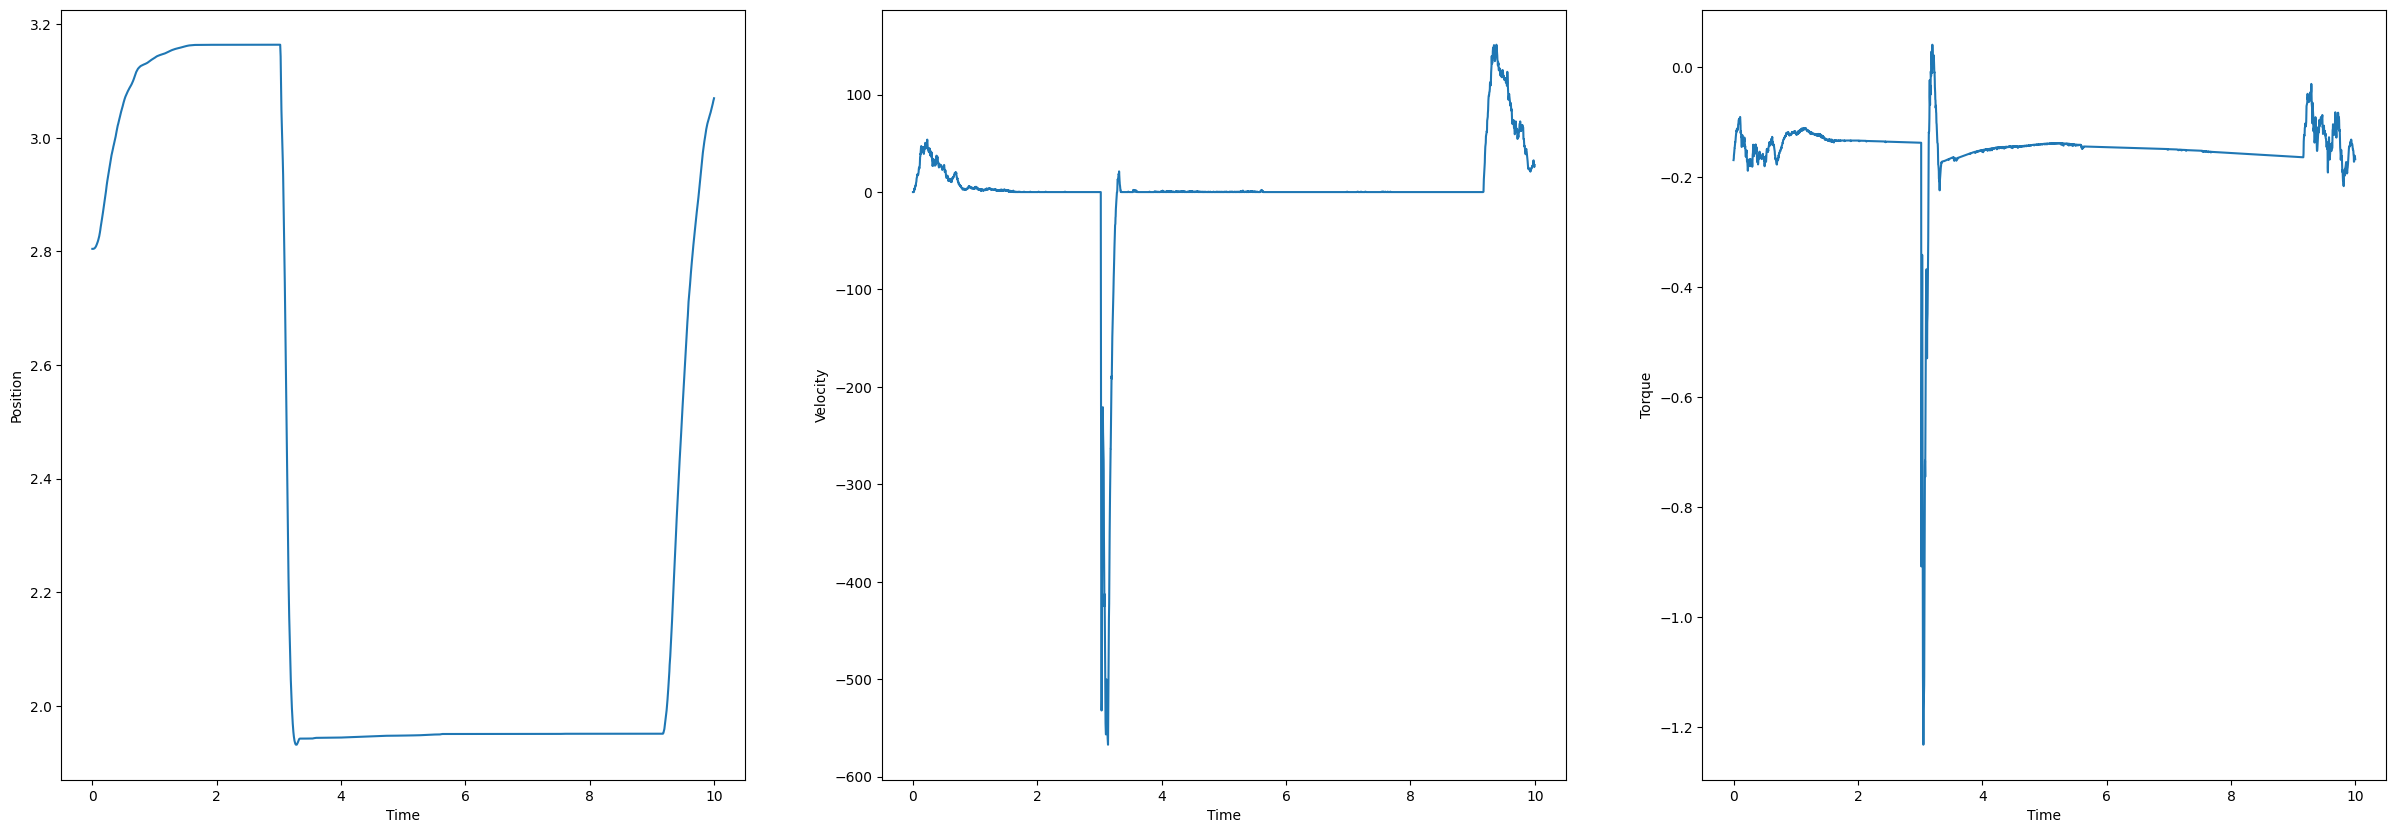

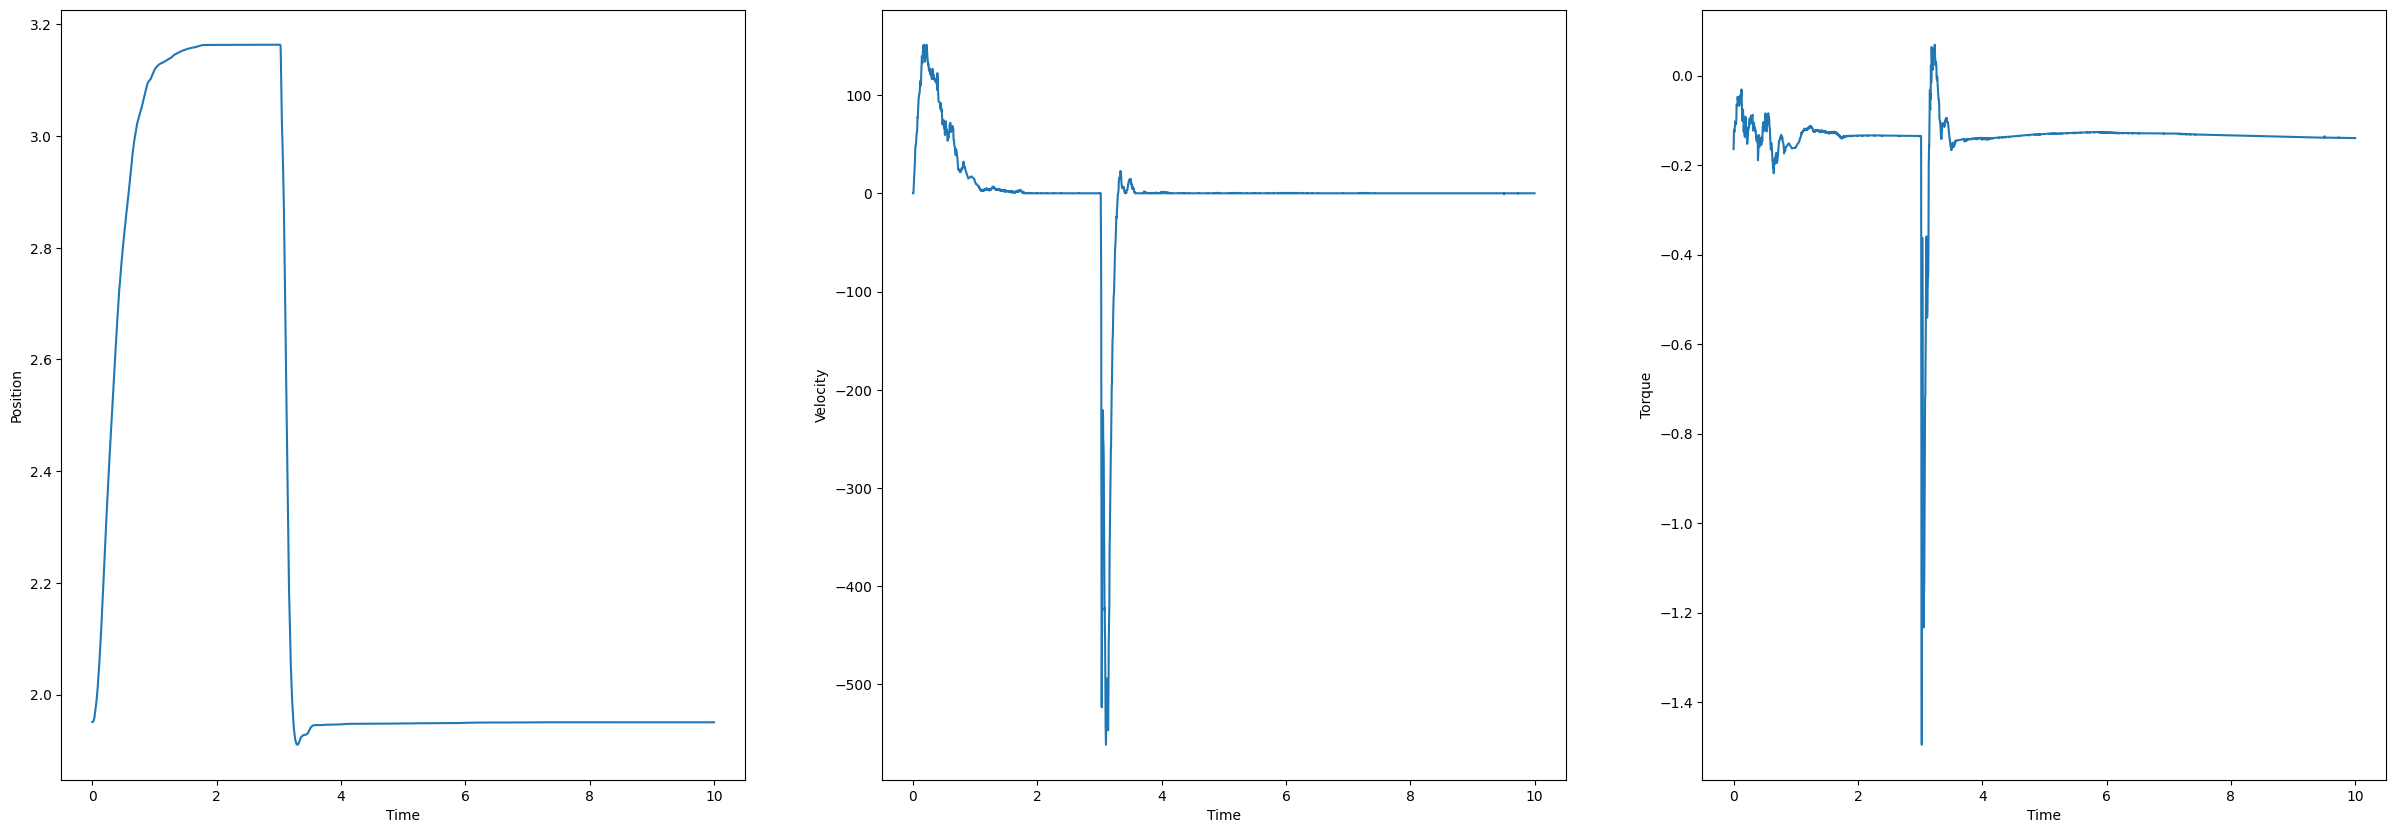

In [98]:
import threading
import time
import matplotlib.pyplot as plt
from odrive.utils import start_liveplotter

time.sleep(2)


# odrv0.axis0.controller.config.control_mode = CONTROL_MODE_POSITION_CONTROL
# odrv0.axis0.controller.config.input_mode = INPUT_MODE_PASSTHROUGH
# odrv0.axis1.controller.config.control_mode = CONTROL_MODE_POSITION_CONTROL
# odrv0.axis1.controller.config.input_mode = INPUT_MODE_PASSTHROUGH

odrv0.axis0.controller.config.control_mode = CONTROL_MODE_POSITION_CONTROL
odrv0.axis0.controller.config.input_mode = INPUT_MODE_POS_FILTER
odrv0.axis1.controller.config.control_mode = CONTROL_MODE_POSITION_CONTROL
odrv0.axis1.controller.config.input_mode = INPUT_MODE_POS_FILTER

odrv0.axis0.trap_traj.config.vel_limit = 2
odrv0.axis0.trap_traj.config.accel_limit = 0.5

odrv0.axis1.trap_traj.config.vel_limit = 2
odrv0.axis1.trap_traj.config.accel_limit = 0.5


def task():
    time_start = time.time()
    time_current = 0
    time_step = 1e-12
    times = []
    pos_estimates = []
    vel_estimates = []
    torque_estimates = []

    while time_current < 10:
        t_0 = time.time()
        times.append(time_current)
        pos_estimates.append(odrv0.axis0.encoder.pos_estimate)
        vel_estimates.append(odrv0.axis0.encoder.vel_estimate*60)# turns/s to rpm
        torque_estimates.append(odrv0.axis0.motor.current_control.Iq_setpoint * odrv0.axis0.motor.config.torque_constant) # Torque [Nm]
        t_1 = time.time()
        time_current = time.time() - time_start
        t_delta = t_1 - t_0
        if t_delta < time_step:
            time.sleep(time_step - t_delta)

    fig = plt.figure()
    fig.set_figwidth(30)
    fig.set_figheight(10)

    plt.subplot(1, 3, 1)
    plt.xlabel("Time")
    plt.ylabel("Position")
    plt.plot(times, pos_estimates)

    plt.subplot(1, 3, 2)
    plt.xlabel("Time")
    plt.ylabel("Velocity")
    plt.plot(times, vel_estimates)

    plt.subplot(1, 3, 3)
    plt.xlabel("Time")
    plt.ylabel("Torque")
    plt.plot(times, torque_estimates)

    # plt.plot(times, torque_estimates)
    plt.show()


thread = threading.Thread(target=task)
thread.start()

final_standing_height = 300

x = final_standing_height
y = 0
q1_1, q2_1, q1_2, q2_2 = q1q2_from_xy(x, y)
odrv0.axis0.controller.config.input_filter_bandwidth = 5
odrv0.axis1.controller.config.input_filter_bandwidth = 5
odrv0.axis0.controller.input_pos = q2_1 * (10 / (2 * math.pi))
odrv0.axis1.controller.input_pos = q1_2 * (10 / (2 * math.pi)) # conversion from set-pos -> radians

time.sleep(3)

x = L1 + L2 - 100
y = 0
q1_1, q2_1, q1_2, q2_2 = q1q2_from_xy(x, y)
odrv0.axis0.controller.config.input_filter_bandwidth = 45
odrv0.axis1.controller.config.input_filter_bandwidth = 45
odrv0.axis0.controller.input_pos = q2_1 * (10 / (2 * math.pi))
odrv0.axis1.controller.input_pos = q1_2 * (10 / (2 * math.pi)) # conversion from set-pos -> radians